
#use multinomial naive bayes algorithm after the other models

# Imports

In [52]:
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import wrangle, model

from importlib import reload
from itertools import product
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pprint import pprint


In [53]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/codeup-data-science/nlp_project/wrangle.py'>

In [54]:
df = wrangle.get_search_csv()
df = wrangle.prep_text(df)

In [55]:
fresh=df.copy()

# REMOVE AFTER HE ADDS THIS GETS MOVED INTO PPREPARE

In [56]:
df.language = df.language.str.lower()

In [57]:
df['language_bigrams'] = df.language

In [58]:
#created class in order to facilitate bigram and trigram creation
class code_language:
  def __init__(self, words, label:str):
    self.words = words
    self.label = label
    self.unique_to_language = set()

  def whole_words(self): 
    return pd.Series(self.words.split())

  def word_counts(self):
    return pd.Series(self.words.split()).value_counts()

  def unique_words(self):
    return set(pd.Series(self.whole_words().unique()))

  def bigrams(self):
    return pd.Series(list(nltk.bigrams(self.words.split())))

  def trigrams(self):
    return pd.Series(list(nltk.ngrams(self.words.split(), 3)))

  def readme_count(self):
    return df[df.language == self.label].word_count.count()


In [59]:
# this initilizes the class objects. 
html = code_language(words=' '.join(df[df.language == 'html'].lemmatized), label='html')
javascript = code_language(words=' '.join(df[df.language == 'javascript'].lemmatized), label='javascript')
r_ = code_language(words=' '.join(df[df.language == 'r'].lemmatized), label='r')
other_ = code_language(words=' '.join(df[df.language == 'other'].lemmatized), label='other')
python_ = code_language(words=' '.join(df[df.language == 'python'].lemmatized), label='python')
all_ = code_language(words=' '.join(df.lemmatized), label='all languages')


In [60]:
def bigram_placement(language):

    if language == 'html':
        language = html.bigrams()
    elif language == 'javascript':
        language = javascript.bigrams()
    elif language == 'r':
        language = r_.bigrams()
    elif language == 'python':
        language = python_.bigrams()
    else:
        language = other_.bigrams()
    return ', '.join(str(e) for e in language.str.join(sep=' ').to_list())
    

In [61]:
df.language_bigrams = df.language_bigrams.apply(bigram_placement)

In [62]:
df.language_bigrams

0      install usage, usage game, game check, check s...
2      readmemd dunk, dunk dunk, dunk dribbble, dribb...
3      getting started, started get, get copy, copy p...
5      install usage, usage game, game check, check s...
7      getting started, started get, get copy, copy p...
                             ...                        
185    getting started, started get, get copy, copy p...
186    getting started, started get, get copy, copy p...
188    readmemd dunk, dunk dunk, dunk dribbble, dribb...
189    getting started, started get, get copy, copy p...
190    ncaahoopr installation, installation function,...
Name: language_bigrams, Length: 179, dtype: object

# Modeling
## Fit Vectorizer
# Setup
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`
### Modeling Preparation
- Create function to vectorize, scale, and split data
- Create word_count feature --> backport to wrangle

Feature Selection

In [63]:
feat_set = ['word_count', 'lemmatized', 'language_bigrams']

### Baseline Prediction and Accuracy

In [64]:

def vectorize_split(df):

    """ 
    Purpose:
        
    ---
    Parameters:
        
    ---
    Returns:
        X_train, y_train, X_validate, y_validate, X_test, y_test: data subsets
    """

    tfidf = TfidfVectorizer()
    df['lemmatized'] = tfidf.fit_transform(df.lemmatized).todense()
    df['language_bigrams']= tfidf.fit_transform(df.language_bigrams).todense()

    scaler = preprocessing.MinMaxScaler()
    scaler.fit_transform(df[['word_count']])

    train_validate, test = train_test_split(df, test_size=.3, random_state=514, stratify=df['language'])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=514, stratify=train_validate['language'])

     # split data into Big X, small y sets 
    X_train = train.drop(columns=['language'])
    y_train = train.language

    X_validate = validate.drop(columns=['language'])
    y_validate = validate.language

    X_test = test.drop(columns=['language'])
    y_test = test.language

    return train, X_train, y_train, X_validate, y_validate, X_test, y_test

In [65]:
train, X_train, y_train, X_validate, y_validate, X_test, y_test = vectorize_split(df)

In [66]:
# formulate baseline prediction ->base prediction is python
train.language.value_counts(normalize=True)

python        0.402299
other         0.252874
r             0.160920
javascript    0.114943
html          0.068966
Name: language, dtype: float64

In [67]:
def compute_metrics(model, X_df, y_df):
    """
    purpose: function executes performs computations to produce evaulation metrics for a given model

    inputs: 
        model: a model that has been previous fit to spec
        X_df: a dataframe featuring the X subset of data for evaluation
        y_df: a dataframe featuring the model target variable

    Returns: a rounded pandas Series that can be adding to an evaulation metric comparison chart
    """
    # Make Predictions
    y_pred = model.predict(X_df)

    # Estimate Probability 
    y_pred_proba = model.predict_proba(X_df)

    #create confusion matrix
    confusion = confusion_matrix(y_df, y_pred)

    #assign results of confusion matrix to variables
    true_negative = confusion[0,0]
    false_positive = confusion[0,1]
    false_negative = confusion[1,0]
    true_positive = confusion[1,1]

    #accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    #true positive rate / recall
    recall = true_positive / (true_positive +false_negative)

    #false positive rate
    false_positive_rate = false_positive / (true_negative + false_positive)

    #true negative rate
    true_negative_rate = true_negative / (true_negative + false_positive)

    #false negative rate
    false_negative_rate = false_negative / (false_negative + true_positive)

    #precision
    precision = true_positive / (true_positive + false_positive)

    #f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    #support
    support_positive = true_positive + false_negative
    support_negative = false_positive + true_negative

    metrics = pd.Series([accuracy, true_positive, false_positive, true_negative, false_negative,\
                        recall, false_positive_rate, true_negative_rate, false_negative_rate, \
                        precision, f1_score, support_positive, support_negative])
                        
    return metrics.round(4)

In [68]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [69]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 'python').mean()

print(f'Baseline Accuracy for \"language\" prediction: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "language" prediction:  40.2%


In [70]:
def create_description_chart(y):

    # formulate baseline accuracy
    baseline_accuracy = (y == 'python').mean()

    descriptions = pd.DataFrame({'Model': 'Baseline', \
                                'Accuracy(Score)': baseline_accuracy,
                                'Type': 'Basic Baseline',
                                'Features Used': 'Baseline Prediction',
                                'Parameters': 'n/a'
                                }, index=[0])
    
    return descriptions

In [71]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [72]:
pd.concat([model_descriptions, pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0]) ], ignore_index=True)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a
1,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a


In [73]:
comparison_chart = model.create_comp_chart()

# Models

## Decision Tree

In [74]:
subsets = [train, X_train, y_train, X_validate, y_validate, X_test, y_test]

In [75]:
def model_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(5,10,1)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_train[features], y_train).values

        score = dtc.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [76]:
model_descriptions, comparison_chart =  model_dtc(feat_set, model_descriptions, comparison_chart, subsets)

In [77]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
5,DTC_4,0.9655,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 9
3,DTC_2,0.9425,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 7
4,DTC_3,0.9425,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 8
2,DTC_1,0.9195,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 6
1,DTC_0,0.8966,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 5


In [78]:
#comparison_chart

## Random Forest

In [79]:
def model_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([5,10,7], [3,2,1]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_train[features], y_train).values

        score = rf.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [80]:
model_descriptions, comparison_chart = model_rf(feat_set, model_descriptions, comparison_chart, subsets)

In [81]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.896600,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 5
2,DTC_1,0.919500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 6
3,DTC_2,0.942500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 7
4,DTC_3,0.942500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 8
5,DTC_4,0.965500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 9
6,RF_0,0.919500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 3"
7,RF_1,0.931000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 2"
8,RF_2,0.954000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 1"
9,RF_3,0.919500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 3"


### Takeaways - Random Forest
* 

## KNN (K-Nearest Neighbors)

In [82]:
## K-Nearest Neighbors
def model_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(3, 7)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_train[features], y_train).values

        score = knn.score(X_train[features], y_train).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

In [83]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

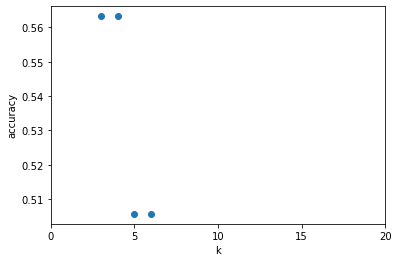

In [84]:
model_descriptions, comparison_chart = model_knn(feat_set, model_descriptions, comparison_chart, subsets)

In [85]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False)

,Model,Accuracy(Score),Type,Features Used,Parameters
11,RF_5,1.000000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 1"
14,RF_8,0.988500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 1"
5,DTC_4,0.965500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 9
8,RF_2,0.954000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 1"
10,RF_4,0.942500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 2"
3,DTC_2,0.942500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 7
4,DTC_3,0.942500,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 8
13,RF_7,0.942500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 2"
7,RF_1,0.931000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 2"
12,RF_6,0.919500,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 3"


## Logistic Regression

In [86]:
def model_lr(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    cees = [.1,.5,1]
    solver = ['newton-cg', 'lbfgs']
    weights = [None, 'balanced']

    selectors = list(product(cees, solver, weights))

    for idx, item in enumerate(selectors):
        model_id = 'LR_'+f'{idx}'
        lr = LogisticRegression(C=item[0],\
                                solver=item[1],
                                class_weight=item[2],
                                max_iter=400,
                                random_state=514)
        
        lr.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(lr, X_train[features], y_train).values

        score = lr.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Logistic Regression',
            'Features Used': f'{feat_set}',
            'Parameters': f'C: {item[0]}, Solver: {item[1]}, Class Weight: {item[2]}'},
            index=[0])
        
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [87]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/nlp_project/model.py'>

In [88]:
model_descriptions, comparison_chart = model_lr(feat_set, model_descriptions, comparison_chart, subsets)

## Model Description and Comparison Charts


In [89]:
model_descriptions.groupby('Type')['Accuracy(Score)'].mean()

Type
Basic Baseline              0.402299
Decision Tree Classifier    0.933320
Knn                         0.534485
Logistic Regression         0.341975
Random Forest               0.946333
Name: Accuracy(Score), dtype: float64

In [93]:
model_descriptions.sort_values(by='Accuracy(Score)',ascending=False).head(20)

,Model,Accuracy(Score),Type,Features Used,Parameters
11,RF_5,1.00000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 1"
14,RF_8,0.98850,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 1"
5,DTC_4,0.96550,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 9
8,RF_2,0.95400,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 1"
3,DTC_2,0.94250,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 7
4,DTC_3,0.94250,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 8
10,RF_4,0.94250,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 2"
13,RF_7,0.94250,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 2"
7,RF_1,0.93100,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 2"
12,RF_6,0.91950,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 3"


In [91]:
#model descriptions
model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
11,RF_5,1.0000,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 10, Leaves: 1"
14,RF_8,0.9885,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 1"
5,DTC_4,0.9655,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 9
8,RF_2,0.9540,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 1"
3,DTC_2,0.9425,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 7


In [42]:
model_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Model            31 non-null     object 
 1   Accuracy(Score)  31 non-null     float64
 2   Type             31 non-null     object 
 3   Features Used    31 non-null     object 
 4   Parameters       31 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.3+ KB


## Model Creation Takeaways
- Had to abandon gridsearch script for lack of feasability
- KNN underperforming with initial set of hyper parameters
- KNN and Logistic regression continued to be low perfoming
- First two rounds of batch model testing did not provide performance above 30%
- 3rd round of testing incorporating bigrams showed dramatic improved.
    - DTC and RF type models hovering above 85%
- 4th round showed large possibility of overfitting on RF models so we reduced depth to below 10

## Validation - Top 5 Models from Train section

Model	| Accuracy(Score)   |Type                       |Features Used                           |Parameters             |
|---    | ---               |---                        |   -----                                |---                    |
|RF_6   |	0.91950         |Random Forest              |word_count, lemmatized, language_bigrams|Depth: 7, Leaves: 3
|RF_0   |	0.91950         |Random Forest              |word_count, lemmatized, language_bigrams|Depth: 5, Leaves: 3
|DTC_1  |   0.91950         |Decision Tree Classifier   |word_count, lemmatized, language_bigrams|Depth: 6
|DTC_0  |	0.89066	        |Decision Tree Classifier	|word_count, lemmatized, language_bigrams|Depth: 5
|KNN_4  |	0.56322	        |K-Nearest Neighbors	    |word_count, lemmatized, language_bigrams|K-Neighbors: 4

In [95]:
def validate_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(5,7,1)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_validate[features], y_validate).values

        score = dtc.score(X_validate[features], y_validate).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

## Random Forest

In [96]:
def validate_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([5,7], [3]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_validate[features], y_validate).values

        score = rf.score(X_validate[features], y_validate).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [102]:
## K-Nearest Neighbors
def validate_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate=subsets[3]
    y_validate=subsets[4]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(4, 5)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_validate[features], y_validate).values

        score = knn.score(X_validate[features], y_validate).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

In [98]:
validate_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

val_comparisons = model.create_comp_chart()

In [99]:
validate_descriptions, val_comparisons =  validate_dtc(feat_set, validate_descriptions, val_comparisons, subsets)

In [100]:
validate_descriptions, val_comparisons =  validate_rf(feat_set, validate_descriptions, val_comparisons, subsets)

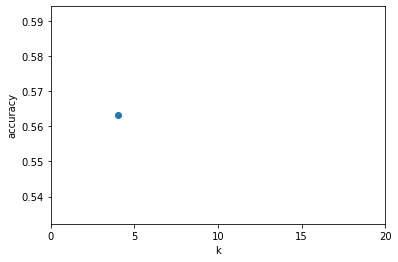

In [103]:
validate_descriptions, val_comparisons =  validate_knn(feat_set, validate_descriptions, val_comparisons, subsets)

In [104]:
validate_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head(5)

,Model,Accuracy(Score),Type,Features Used,Parameters
1,DTC_0,0.868400,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 5
2,DTC_1,0.842100,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 6
3,RF_0,0.763200,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 5, Leaves: 3"
4,RF_1,0.763200,Random Forest,"['word_count', 'lemmatized', 'language_bigrams']","Depth: 7, Leaves: 3"
0,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a


In [ ]:
# val_comparisons

## Validation Takeaways
- Massive performance drop from Train set. 
- Indicative of over fitting. Made numerous adjustements to control for this. 
- Logistic Regression never made it to validation 
- Adjusting input data for hopeful performance gains.
- Validation Performance on Top 5 from Train

## Test
- The Top performing model from Validation

In [105]:
test_description = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [110]:
def test_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_test=subsets[5]
    y_test=subsets[6]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(5,6,1)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_test[features], y_test).values

        score = dtc.score(X_test[features], y_test).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [111]:
test_comparisons = model.create_comp_chart()

In [114]:
test_description, test_comparisons = test_dtc(feat_set, test_description, test_comparisons, subsets)

In [115]:
test_description

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.402299,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.777800,Decision Tree Classifier,"['word_count', 'lemmatized', 'language_bigrams']",Depth: 5



## Modeling Takeaways
- Things did not go as plan.
- Had to abandon gridsearch idea
- Logistic Regression never provided much performance gain above baseline
- DTC models consistenly peformed well
- Final Modele had 37% performamce gain above baseline